In [14]:
import wrangle
import evaluate
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures



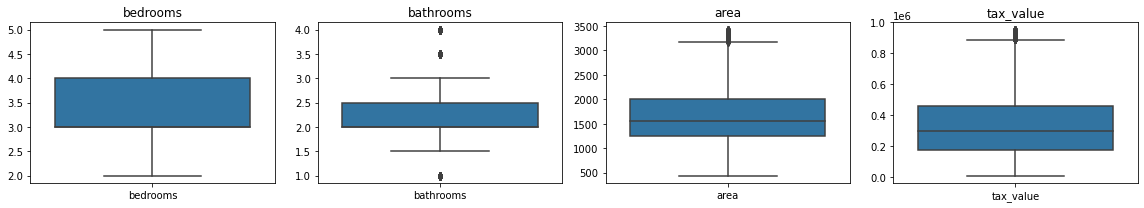

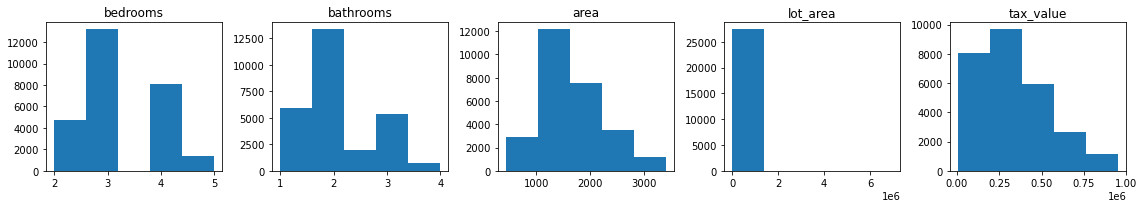

In [2]:
train, validate, test = wrangle.wrangle_zillow()

# ASK NATURAL LANGUAGE QUESTION HERE

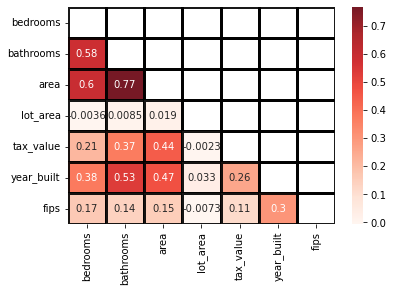

In [3]:
evaluate.create_heat_map(train)

# PROVIDE NATURAL LANGUAGE ANSWER HERE DISCUSSING CORR COEFFICIENTS

# ENTER QUESTION HERE

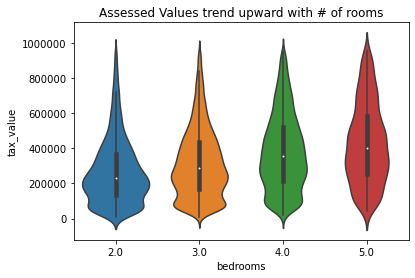

Correlation Coefficient: 0.2116919401026855
P-value: 5.183523254906572e-275


In [4]:
evaluate.create_violin_chart_bedrooms(train)

# PROVIDE ANSWER HERE (address hypothesis result also)

# NATURAL LANGUAGE QUESTION GOES HERE 

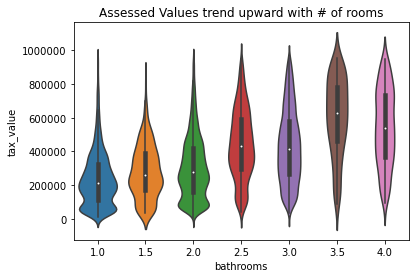

Correlation Coefficient: 0.36935991287106845
P-value: 0.0


In [5]:
evaluate.create_violin_chart_bathrooms(train)

# PROVIDE ANSWER HERE (address hypothesis result also)

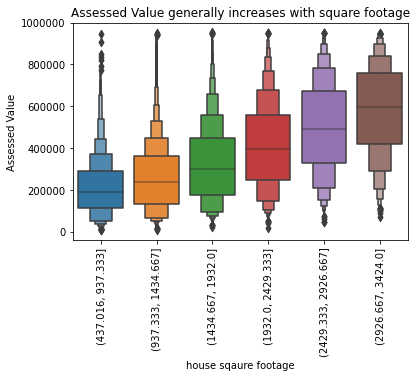

Correlation Coefficient: 0.44486879390478085
P-value: 0.0


In [6]:
evaluate.create_boxen_plot_area(train)

# ANSWER QUESTION IN NATURAL LANGUAGE (address hypothesis test also)

# ASK QUESTION IN NATURAL LANGUAGE HERE 

In [7]:
evaluate.feature_engineer(train,validate,test)

train.head()

,bedrooms,bathrooms,area,lot_area,tax_value,year_built,fips,lot_living_ratio,non_bed_bath_area
0,4.0,3.0,3105.0,7140.0,514262.0,1986.0,6059.0,0.434874,2979.0
1,3.0,1.0,1010.0,6245.0,144398.0,1950.0,6037.0,0.161729,728.0
2,3.0,1.0,1154.0,7035.0,45731.0,1947.0,6037.0,0.164037,872.0
3,3.0,2.0,1546.0,6630.0,154605.0,1973.0,6111.0,0.233183,1414.0
4,3.0,1.0,940.0,6080.0,436455.0,1957.0,6059.0,0.154605,658.0


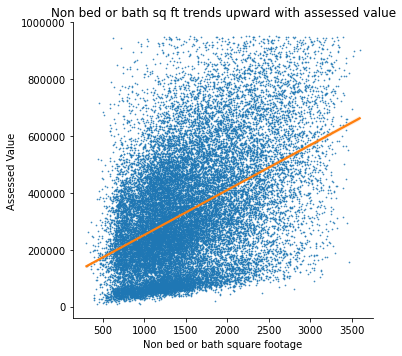

Correlation Coefficient: 0.4538605459106819
P-value: 0.0


In [8]:
evaluate.regplot_engineered_feat(train)

# Answer question here 

In [9]:
X_train, y_train, X_validate, y_validate, X_test, y_test=evaluate.X_and_y_split(train,validate,test)



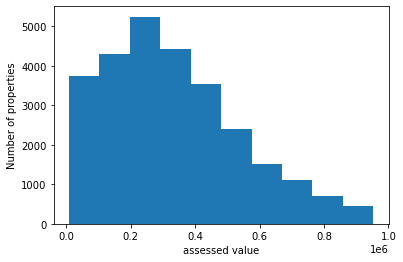

In [10]:
evaluate.target_var_dist(y_train)

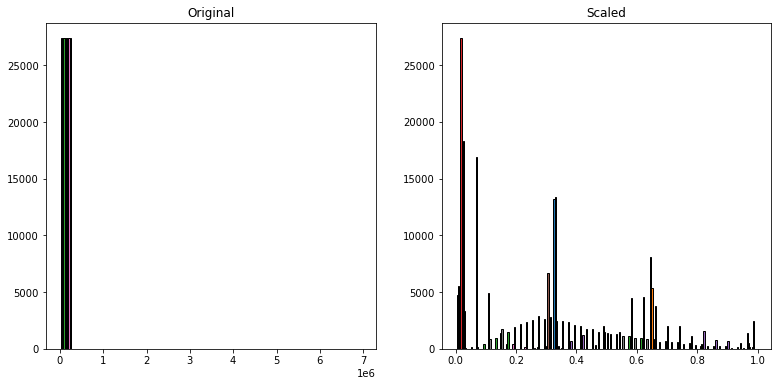

In [11]:
X_train_scaled, X_validate_scaled, X_test=evaluate.scale_data(X_train,X_validate,X_test)

In [12]:
evaluate.calc_baseline(y_train,y_validate)

RMSE using Mean
Train/In-Sample:  206984.12 
Validate/Out-of-Sample:  210683.12
RMSE using Median
Train/In-Sample:  209863.51 
Validate/Out-of-Sample:  214214.18


# discuss baseline

# OLS MODEL

In [17]:
import warnings
warnings.filterwarnings("ignore")

# create the model object
lm = LinearRegression(normalize=True)

# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm)**(1/2)

# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  183755.57613736103 
Validation/Out-of-Sample:  187178.24342891522


0    514262.0
1    144398.0
2     45731.0
3    154605.0
4    436455.0
Name: tax_value, dtype: float64